In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pickle #allows to serialize and deserialize Python objects.
from mpl_toolkits.mplot3d import Axes3D
from tqdm import trange,tqdm #allows to create progress bars
import os

#change the paths to the correct paths on your computer
directory_path_params = r"C:\Users\Callens.R\Documents\Kms\1MA sem 2\2. DS425 Intelligent decision support methods\Project weemaes_callens\DS425-Blackjack\data\params"

In this code the winrate is calculated for a range of reward functions.  So that the optimal reward function can be found before going deeper into the hyperparameters.

In [3]:
env = gym.make('Blackjack-v1')

In [4]:
# Define the state space
player_sum_space = range(4, 22)  # possible player hand values (4, 5, ..., 20, 21)
dealer_card_space = range(1, 11)  # possible dealer up card values (2, 3, ..., 10, 11)
usable_ace_space = [False, True]  # whether the player has a usable ace

state_space = []
for player_sum in player_sum_space:
    for dealer_card in dealer_card_space:
        for usable_ace in usable_ace_space:
            state_space.append((player_sum, dealer_card, usable_ace))

# This creates an array of length 306, which is the number of possible states in the game of blackjack. 
# Each state is a tuple of the player’s sum, the dealer’s card, and whether the player has a usable ace.

# Define the action space
action_space = [0, 1]  # hit or stick
# Get the size of the state and action spaces
num_states = len(state_space)
num_actions = len(action_space)

Change the reward function and chek the influence on the winrate. The value of the number of episodes of the q table, games and hyperparameters stay cosntant

In [5]:
# Hyperparameters
alpha = 0.05  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Epsilon-greedy parameter

rewarddraw_range = np.array([0])
rewardwin_range = np.arange(0.2,2.1,0.1)
rewardloss_range = np.arange(-1.5,-0.2,0.1)

# Initialize arrays to store win rate for each combination of hyperparameters
win_rates = np.zeros((rewarddraw_range.size, rewardwin_range.size, rewardloss_range.size))

# Vary num_episodes and compute winrate
num_episodes = 1000000
winrates = []
for i, rewarddraw in enumerate(rewarddraw_range):
    for j, rewardwin in enumerate(rewardwin_range):
        for k, rewardloss in enumerate(rewardloss_range):

            # Check if a file already exists for this Q-table
            filename = f"{directory_path_params}/episodes{num_episodes}_q_table_alpha{alpha}_gamma{gamma}_epsilon{epsilon}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
            if os.path.exists(filename):
                #print(f"{filename} already exists, loading...")
                with open(filename, 'rb') as f:
                    Q_table = pickle.load(f)
            else:
                Q_table = np.zeros((len(state_space), len(action_space)))
                for episode in range(num_episodes):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        # Epsilon-greedy action selection
                        if np.random.random() < epsilon:
                            action = np.random.choice(action_space)
                        else:
                            action = np.argmax(Q_table[state_space.index(state)])

                        # Take the action
                        next_state, reward, done, terminal, dic = env.step(action)
                        
                        if reward == 0:
                            rewardcalc = rewarddraw
                        elif reward == 1:
                            rewardcalc = rewardwin
                        elif reward == -1:
                            rewardcalc = rewardloss
                        # Update Q-value if you busted, necessary because Q_table(next_state) does not exist if you bust
                        if next_state not in state_space:
                            Q_table[state_space.index(state)][action] += alpha * (rewardcalc - Q_table[state_space.index(state)][action])
                            break

                        # Update Q-value for current state-action pair
                        Q_table[state_space.index(state)][action] += alpha * (rewardcalc + gamma * np.max(Q_table[state_space.index(next_state)]) - Q_table[state_space.index(state)][action])

                        state = next_state

                # Save the Q-table to a file using pickle
                with open(filename, 'wb') as f:
                    pickle.dump(Q_table, f)
            
            filename = f"{directory_path_params}/episodes{num_episodes}_winrate_alpha{alpha}_gamma{gamma}_epsilon{epsilon}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
            if os.path.exists(filename):
                #print(f"{filename} already exists, loading...")
                with open(filename, 'rb') as f:
                    win_rate = pickle.load(f)
            else:
                # Evaluate the performance of the Q-table by playing num_games games
                num_wins = 0
                num_losses = 0
                num_draws = 0
                num_games = 1000000
                # Initialize arrays to store win rate for each combination of hyperparameters
                win_rates = np.zeros((rewarddraw_range.size, rewardwin_range.size, rewardloss_range.size))

                for n in range(num_games):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        action = np.argmax(Q_table[state_space.index(state)])
                        next_state, reward, done, terminal, dic = env.step(action)
                        state = next_state
                        if done and reward == 1:
                            num_wins += 1
                        elif done and reward == -1:
                            num_losses += 1
                        elif done and reward == 0:
                            num_draws += 1

                win_rate = num_wins / (num_games - num_draws)
                filename = f"{directory_path_params}/episodes{num_episodes}_winrate_alpha{alpha}_gamma{gamma}_epsilon{epsilon}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
                with open(filename, 'wb') as f:
                    pickle.dump(win_rate, f)
            win_rates[0,j, k] = win_rate




KeyboardInterrupt: 

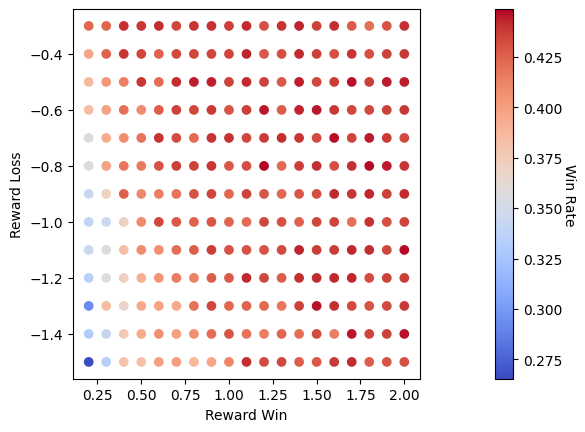

In [ ]:
# Visualize results
win_grid, loss_grid = np.meshgrid(rewardwin_range, rewardloss_range, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(win_grid, loss_grid, c=win_rates.flatten(), cmap='coolwarm')
ax.set_xlabel('Reward Win')
ax.set_ylabel('Reward Loss')

# Add colorbar
cbar = fig.colorbar(sc, pad = 0.15)
cbar.ax.set_ylabel('Win Rate', rotation=270, labelpad=10)

plt.show()

In [ ]:
# Find indices of maximum win rate
max_idx = np.unravel_index(np.argmax(win_rates), win_rates.shape)

# Extract corresponding hyperparameters
best_rewarddraw = rewarddraw_range[max_idx[0]]
best_rewardwin = rewardwin_range[max_idx[1]]
best_rewardloss = rewardloss_range[max_idx[2]]

# Print best hyperparameters and corresponding win rate
print("Best reward parameters:")
print(f"Reward Draw: {best_rewarddraw}")
print(f"Reward Win: {best_rewardwin}")
print(f"Reward Loss: {best_rewardloss}")
print(f"Win rate: {win_rates[max_idx]}")


Best reward parameters:
Reward Draw: 0
Reward Win: 1.2000000000000004
Reward Loss: -0.7999999999999994
Win rate: 0.448651946309743


effe een test => run deze code niet meer!

In [ ]:

print("Are you sure to run this code, because it doesn't use any data so it will take a long time to run this")
# Hyperparameters
alpha = 0.05  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Epsilon-greedy parameter

rewarddraw_range = np.array([0])
rewardwin_range = np.array([1])
rewardloss_range = np.array([-1])

# Initialize arrays to store win rate for each combination of hyperparameters
win_rates = np.zeros((rewarddraw_range.size, rewardwin_range.size, rewardloss_range.size))

# Vary num_episodes and compute winrate
num_episodes = 1000000
winrates = []
for i, rewarddraw in enumerate(rewarddraw_range):
    for j, rewardwin in enumerate(rewardwin_range):
        for k, rewardloss in enumerate(rewardloss_range):
                Q_table = np.zeros((len(state_space), len(action_space)))
                for episode in range(num_episodes):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        # Epsilon-greedy action selection
                        if np.random.random() < epsilon:
                            action = np.random.choice(action_space)
                        else:
                            action = np.argmax(Q_table[state_space.index(state)])

                        # Take the action
                        next_state, reward, done, terminal, dic = env.step(action)
                        
                        if reward == 0:
                            rewardcalc = rewarddraw
                        elif reward == 1:
                            rewardcalc = rewardwin
                        elif reward == -1:
                            rewardcalc = rewardloss
                        # Update Q-value if you busted, necessary because Q_table(next_state) does not exist if you bust
                        if next_state not in state_space:
                            Q_table[state_space.index(state)][action] += alpha * (rewardcalc - Q_table[state_space.index(state)][action])
                            break

                        # Update Q-value for current state-action pair
                        Q_table[state_space.index(state)][action] += alpha * (rewardcalc + gamma * np.max(Q_table[state_space.index(next_state)]) - Q_table[state_space.index(state)][action])

                        state = next_state

                # Evaluate the performance of the Q-table by playing num_games games
                num_wins = 0
                num_losses = 0
                num_draws = 0
                num_games = 1000000
                # Initialize arrays to store win rate for each combination of hyperparameters
                win_rates = np.zeros((rewarddraw_range.size, rewardwin_range.size, rewardloss_range.size))

                for i in range(num_games):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        action = np.argmax(Q_table[state_space.index(state)])
                        next_state, reward, done, terminal, dic = env.step(action)
                        state = next_state
                        if done and reward == 1:
                            num_wins += 1
                        elif done and reward == -1:
                            num_losses += 1
                        elif done and reward == 0:
                            num_draws += 1

                win_rate = num_wins / (num_games - num_draws)
                win_rates[0,j, k] = win_rate


# Visualize results
draw_grid, win_grid, loss_grid = np.meshgrid(rewarddraw_range, rewardwin_range, rewardloss_range, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(draw_grid, win_grid, loss_grid, c=win_rates.flatten(), cmap='coolwarm')
ax.set_xlabel('Reward Draw')
ax.set_ylabel('Reward Win')
ax.set_zlabel('Reward Loss')

# Add colorbar
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('Win Rate', rotation=270, labelpad=10)

plt.show()

Are you sure to run this code, because it doesn't use any data so it will take a long time to run this


NameError: name 'np' is not defined